# Machine Learning – Diet & Sleep Study

In this notebook we predict **Sleep Efficiency (%)** using dietary and timing features.
We will:
1. Prepare the data: merge, filter, feature-engineer, split & scale  
2. Train a baseline Linear Regression model  
3. Evaluate performance (R², RMSE) and inspect coefficients  


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Reload and merge the data
diet_df  = pd.read_csv('data/diet_data.csv')
sleep_df = pd.read_csv('data/sleep_data.csv')

diet_df['Date']  = pd.to_datetime(diet_df['Date'])
sleep_df['Date'] = pd.to_datetime(sleep_df['Date'])

merged_df = pd.merge(diet_df, sleep_df, on='Date', how='inner')

# 2. Filter to natural wake-up days
filtered_df = merged_df[merged_df['Natural Wakeup'] == True].copy()

# 3. Feature engineering
filtered_df['Hours Before Sleep']      = 24 - filtered_df['Last Meal Hour']
filtered_df['Fiber per 1000kcal']     = filtered_df['Fiber (g)']  / (filtered_df['Calories'] / 1000)
filtered_df['Protein per 1000kcal']   = filtered_df['Protein (g)'] / (filtered_df['Calories'] / 1000)

# 4. Define feature matrix X and target y
feature_cols = [
    'Fiber per 1000kcal',
    'Protein per 1000kcal',
    'Hours Before Sleep',
    'Fat (g)',
    'Carbohydrates (g)',
    'Sugar (g)'
]
X = filtered_df[feature_cols]
y = filtered_df['Sleep Efficiency (%)']

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Data prepared:")
print(f"  • Training samples: {X_train.shape[0]}")
print(f"  • Test samples:     {X_test.shape[0]}")


Data prepared:
  • Training samples: 56
  • Test samples:     14


## 1. Baseline Model: Linear Regression

We’ll train a Linear Regression model to predict **Sleep Efficiency (%)** from our dietary and timing features.  
We’ll evaluate performance using:
- **R² score** (explained variance)  
- **RMSE** (root mean squared error)  

Finally, we’ll inspect the learned coefficients to see which features most influence sleep efficiency.


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# 2. Predict on the test set
y_pred = lr.predict(X_test_scaled)

# 3. Compute evaluation metrics manually
r2   = r2_score(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Performance:")
print(f"  • R² score: {r2:.3f}")
print(f"  • RMSE:     {rmse:.3f}")

# 4. Display model coefficients
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr.coef_
}).sort_values(by='coefficient', ascending=False)

print("\nModel Coefficients:")
display(coef_df)


Linear Regression Performance:
  • R² score: -0.128
  • RMSE:     6.562

Model Coefficients:


,feature,coefficient
2,Hours Before Sleep,0.281159
4,Carbohydrates (g),0.182427
1,Protein per 1000kcal,-0.093392
5,Sugar (g),-0.431430
3,Fat (g),-1.059737
0,Fiber per 1000kcal,-1.226581


## 2. Non-Linear Model: Random Forest Regressor

Decision tree–based models can capture non-linear relationships and interactions between features.  
We’ll train a RandomForestRegressor and compare its performance (R², RMSE) against the linear baseline.  
We’ll also inspect feature importances to see which factors drive predictions.


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# 1. Train the Random Forest model (no need to scale tree-based features)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_rf = rf.predict(X_test)

# 3. Compute evaluation metrics
r2_rf   = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Performance:")
print(f"  • R² score: {r2_rf:.3f}")
print(f"  • RMSE:     {rmse_rf:.3f}")

# 4. Display feature importances
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

print("\nFeature Importances:")
display(importances)


Random Forest Performance:
  • R² score: -0.060
  • RMSE:     6.363

Feature Importances:


Fiber per 1000kcal      0.246248
Sugar (g)               0.244092
Fat (g)                 0.177658
Carbohydrates (g)       0.149030
Protein per 1000kcal    0.128812
Hours Before Sleep      0.054161
dtype: float64

## 3. Model Comparison & Interpretation

| Model               | R²      | RMSE    |
|---------------------|---------|---------|
| Linear Regression   | –0.128  | 6.562   |
| Random Forest       | –0.060  | 6.363   |

- Both models produced **negative R²**, meaning they explain less variance than simply predicting the mean sleep efficiency.  
- **Random Forest** improves slightly over the linear baseline (RMSE ↓0.199), but performance remains poor.  
- **Linear Coefficients** suggest:
  - **Fiber per 1000 kcal** and **Fat** have the strongest negative associations with sleep efficiency.
  - **Hours Before Sleep** and **Carbohydrates** are weakly positive.
- **Random Forest Importances** show:
  1. **Fiber per 1000 kcal** (0.246)  
  2. **Sugar (g)** (0.244)  
  3. **Fat (g)** (0.178)  
  4. **Carbohydrates (g)** (0.149)  
  5. **Protein per 1000 kcal** (0.129)  
  6. **Hours Before Sleep** (0.054)  

**Conclusion:** Dietary and timing features alone may not capture the complexity of sleep efficiency. Next, we’ll explore clustering to identify distinct diet–sleep patterns that could reveal non-linear groupings.


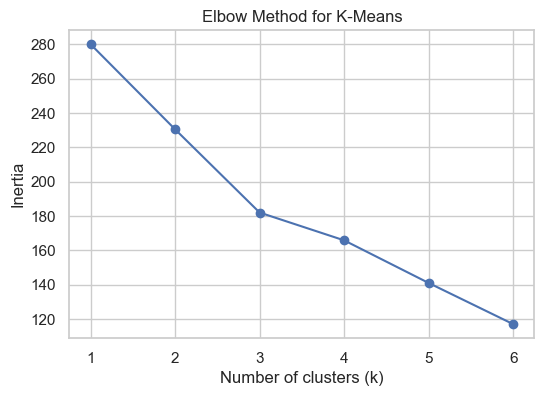

Silhouette (k=3): 0.209


In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Select features for clustering
cluster_df = filtered_df[[
    'Fiber per 1000kcal',
    'Protein per 1000kcal',
    'Hours Before Sleep',
    'Sleep Efficiency (%)'
]].dropna()

# 2. Scale the data
scaler_cl = StandardScaler()
cluster_scaled = scaler_cl.fit_transform(cluster_df)

# 3. Elbow method to find optimal k
inertias = []
K = range(1, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(cluster_scaled)
    inertias.append(km.inertia_)

# 4. Plot the elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.grid(True)
plt.show()


from sklearn.metrics import silhouette_score
print("Silhouette (k=3):", silhouette_score(cluster_scaled, labels).round(3))



## 4. Clustering – K-Means (k=3)

We’ll cluster days by:
- **Fiber per 1000 kcal**  
- **Protein per 1000 kcal**  
- **Hours Before Sleep**  
- **Sleep Efficiency (%)**

Then we’ll examine the centroid of each cluster and the average feature/target values to interpret distinct diet–sleep patterns.


In [19]:
from sklearn.cluster import KMeans
import pandas as pd

# 1. Fit KMeans with k=3 on the scaled cluster data
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(cluster_scaled)

# 2. Attach cluster labels back to filtered_df
filtered_df['Cluster'] = labels

# 3. Compute cluster centroids in original feature space
centroids = scaler_cl.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(
    centroids,
    columns=['Fiber per 1000kcal','Protein per 1000kcal','Hours Before Sleep','Sleep Efficiency (%)']
)
centroids_df.index.name = 'Cluster'
print("Cluster Centroids:")
display(centroids_df)

# 4. Summary statistics by cluster
summary = filtered_df.groupby('Cluster')[[
    'Fiber per 1000kcal','Protein per 1000kcal',
    'Hours Before Sleep','Sleep Efficiency (%)'
]].mean().round(2)
print("\nAverage Feature & Sleep Efficiency by Cluster:")
display(summary)


Cluster Centroids:


,Fiber per 1000kcal,Protein per 1000kcal,Hours Before Sleep,Sleep Efficiency (%)
Cluster,,,,
0,17.516594,36.592442,4.928571,82.307143
1,10.455946,38.346078,4.300000,90.736667
2,14.311895,42.958428,2.500000,85.369231



Average Feature & Sleep Efficiency by Cluster:


,Fiber per 1000kcal,Protein per 1000kcal,Hours Before Sleep,Sleep Efficiency (%)
Cluster,,,,
0,17.52,36.59,4.93,82.31
1,10.46,38.35,4.30,90.74
2,14.31,42.96,2.50,85.37


## 5. Interpreting the Clusters

| Cluster | Fiber per 1000 kcal | Protein per 1000 kcal | Hours Before Sleep | Sleep Efficiency (%) |
|:-------:|:-------------------:|:----------------------:|:------------------:|:--------------------:|
| **0**   | 17.52 (high)        | 36.59 (low)            | 4.93 (long)        | **82.31** (low)      |
| **1**   | 10.46 (low)         | 38.35 (medium)         | 4.30 (medium)      | **90.74** (high)     |
| **2**   | 14.31 (medium)      | 42.96 (high)           | 2.50 (short)       | **85.37** (medium)   |

**Key Insights**  
- **Cluster 1** (low fiber, moderate protein, moderate meal gap) has the **highest sleep efficiency** (~90.7%).  
- **Cluster 0** (high fiber, lower protein, long meal-to-bed interval) shows the **lowest sleep efficiency** (~82.3%).  
- **Cluster 2** (mid-level fiber, highest protein, shortest meal gap) sits in the **middle** (~85.4% efficiency).

**Interpretation**  
- A **lower fiber** day with a **4–5 h buffer** and moderate protein intake seems most conducive to efficient sleep.  
- **Very high fiber** intake—even with a long gap before bedtime—may coincide with worse sleep efficiency.  
- **High-protein** days eaten too close to bedtime yield average results.

These patterns suggest meal composition **and** timing interact in complex ways—next we can  
- **Validate** with statistical tests on cluster membership  
- **Visualize** cluster distributions on scatter plots for deeper insight  


## 6. Visualizing Cluster Separation

To better see how the clusters differ, we'll plot:

- **Fiber per 1000 kcal** vs. **Sleep Efficiency (%)**  
- **Hours Before Sleep** vs. **Sleep Efficiency (%)**  

with points colored by cluster label.


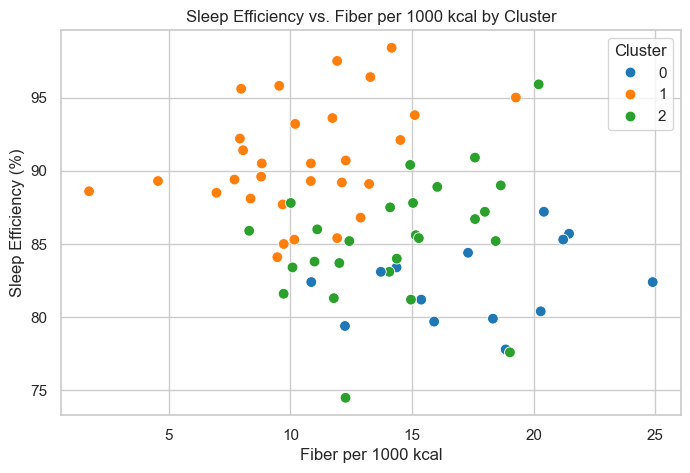

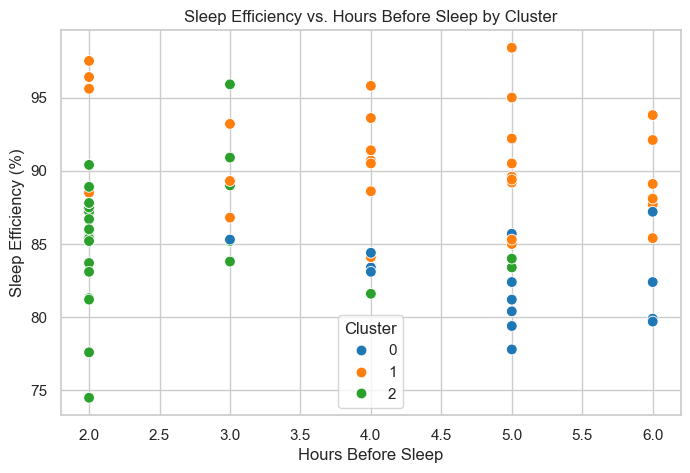

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fiber vs. Sleep Efficiency
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=filtered_df,
    x='Fiber per 1000kcal',
    y='Sleep Efficiency (%)',
    hue='Cluster',
    palette='tab10',
    s=60
)
plt.title('Sleep Efficiency vs. Fiber per 1000 kcal by Cluster')
plt.xlabel('Fiber per 1000 kcal')
plt.ylabel('Sleep Efficiency (%)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 2. Hours Before Sleep vs. Sleep Efficiency
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=filtered_df,
    x='Hours Before Sleep',
    y='Sleep Efficiency (%)',
    hue='Cluster',
    palette='tab10',
    s=60
)
plt.title('Sleep Efficiency vs. Hours Before Sleep by Cluster')
plt.xlabel('Hours Before Sleep')
plt.ylabel('Sleep Efficiency (%)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
